In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from flows import *
from utl import *
from load_data import *

from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [2]:
DTYPE=tf.float32
NP_DTYPE=np.float32
num_bijectors = 6
steps = 2000
lr = 1e-3
datafile = 'realTraffic.csv'

In [5]:
X_data = pd.read_csv(datafile, index_col=0)

In [6]:
X_data = X_data.values.astype(np.float32)
X_data = StandardScaler().fit_transform(X_data)

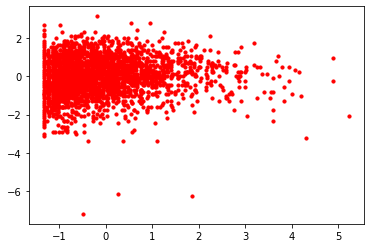

In [7]:
# Plot joint distribution
plt.scatter(X_data[:, 0], X_data[:, 1], s=10, color='red')

In [8]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros([2], tf.float32))

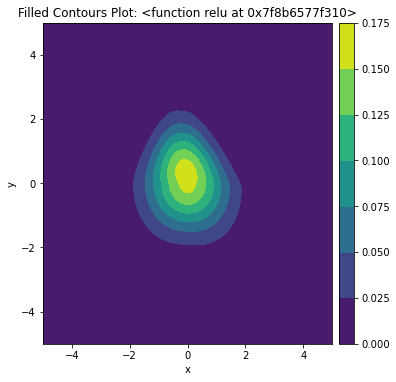

In [9]:
# sample from the base distribution

activation = tf.nn.relu
flow = IAF(base_dist, num_bijectors, hidden_units=[256, 256], activation=activation)
plot_contour_prob([flow], scale_fig=6, title=[activation])

# Training an IAF Flow

steps: 0 	 loss: 2.8861842
steps: 100 	 loss: 2.6079342
steps: 200 	 loss: 2.600613
steps: 300 	 loss: 2.5917056
steps: 400 	 loss: 2.5850577
steps: 500 	 loss: 2.5851173
steps: 600 	 loss: 2.5881114
steps: 700 	 loss: 2.584018
steps: 800 	 loss: 2.5830686
steps: 900 	 loss: 2.5891905
steps: 1000 	 loss: 2.571454
steps: 1100 	 loss: 2.57207
steps: 1200 	 loss: 2.5655048
steps: 1300 	 loss: 2.5751255
steps: 1400 	 loss: 2.5667012
steps: 1500 	 loss: 2.5742464
steps: 1600 	 loss: 2.5786107
steps: 1700 	 loss: 2.5672073
steps: 1800 	 loss: 2.5728152
steps: 1900 	 loss: 2.5596297


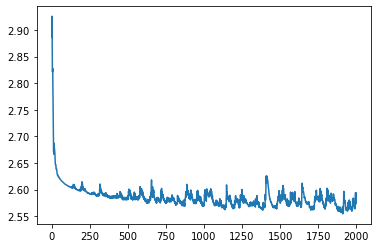

In [10]:
losses = train_dist_routine(X_data, flow, learning_rate=lr, steps=steps)
plt.plot(losses)

In [11]:
# Make samples
names, samples = make_samples(base_dist, flow, n_samples=X_data.shape[0])
visualize_training_data(X_data, samples)

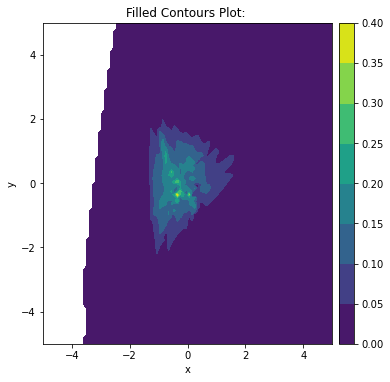

In [14]:
plot_contour_prob([flow], scale_fig=6)

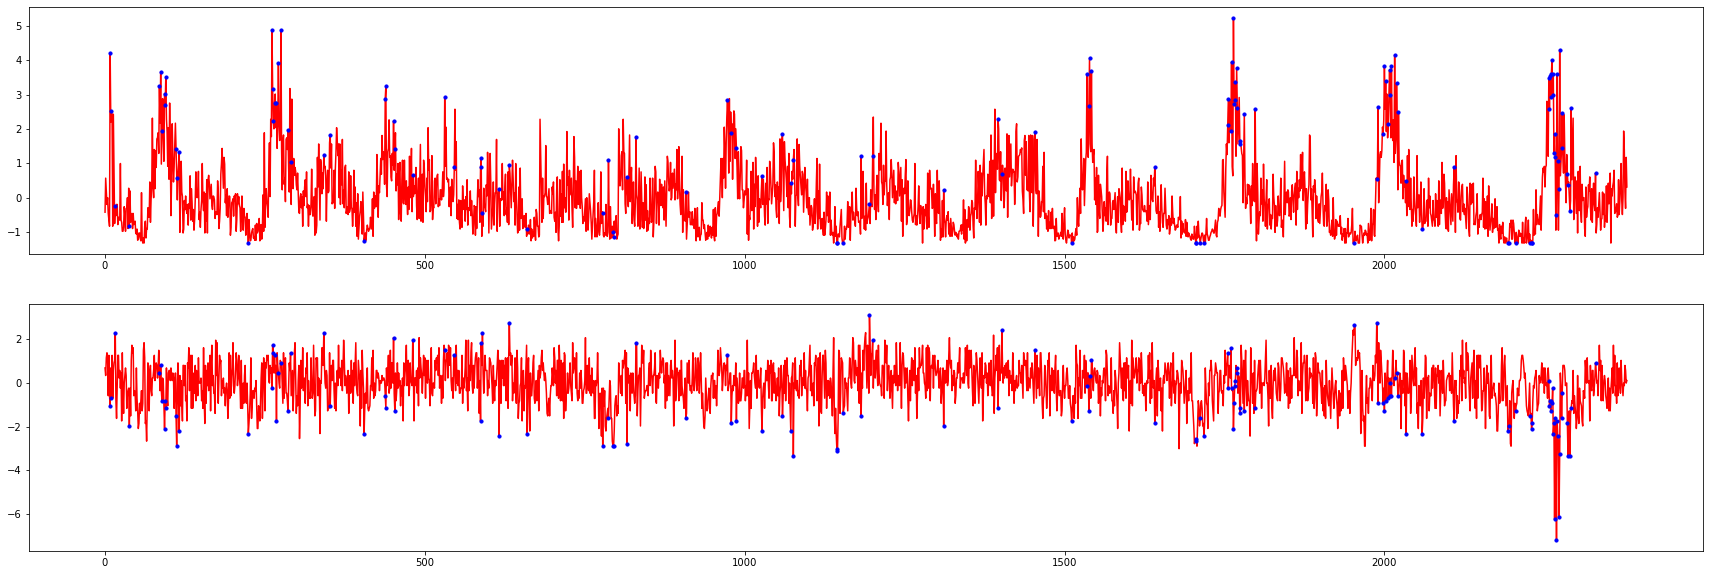

In [15]:
# TODO: how to determin the threshold?
anomalies = detect_anomalies(data=X_data, model=flow, threshold=0.01)
fig, axes = plt.subplots(2, figsize=(30,10))
x = np.arange(len(X_data[:, 0]))
axes[0].plot(x, X_data[:, 0], color='red', zorder=0)
axes[0].scatter(anomalies, X_data[anomalies, 0], s=10, color='blue', zorder=1)

axes[1].plot(x, X_data[:, 1], color='red', zorder=0)
axes[1].scatter(anomalies, X_data[anomalies, 1], color='blue', s=10, zorder=1)

plt.show()

# Data Distribution Before/After Training

In [16]:
temp = flow.bijector.inverse(X_data).numpy()

## Before

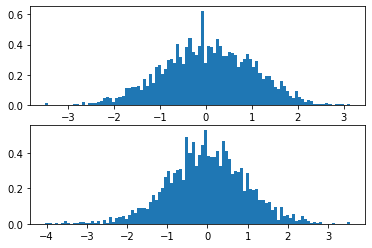

In [17]:
fig, axes = plt.subplots(2)
axes[0].hist(temp[:, 0], bins=100, density=True)
axes[1].hist(temp[:, 1], bins=100, density=True)
plt.show()

## After

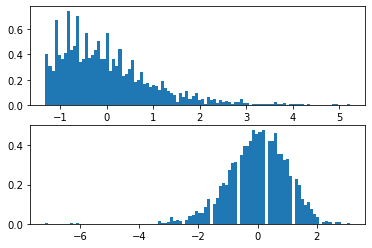

In [18]:
fig, axes = plt.subplots(2)
axes[0].hist(X_data[:, 0], bins=100, density=True)
axes[1].hist(X_data[:, 1], bins=100, density=True)
plt.show()

# Generate Data for the Classifier

In [30]:
factor = 2
anomalies = sample_anomalies(flow, factor=factor, n_samples=3000)
normals = sample_normals(flow, factor=factor, n_samples=10000)

In [31]:
anomalies = pd.DataFrame(anomalies)
normals = pd.DataFrame(normals)
anomalies.columns = ['v1', 'v2']
normals.columns = ['v1', 'v2']
anomalies['label'] = 1
normals['label'] = 0

In [32]:
clr_data = pd.concat([anomalies, normals], axis=0)
clr_data = clr_data.dropna()
clr_data = shuffle(clr_data)

In [36]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(clr_data[['v1', 'v2']], clr_data['label'], test_size=0.33, random_state=42)
clf, score = RFClassifier(X_train, y_train, X_test, y_test)
print('precision: {}'.format(score[0]))
print('recall: {}'.format(score[1]))
print('fscore: {}'.format(score[2]))
print('support: {}'.format(score[3]))

precision: [1.         0.99693878]
recall: [0.99909448 1.        ]
fscore: [0.99954703 0.99846704]
support: [3313  977]


# Apply Classifier on Real Data

In [37]:
y_data = clf.predict(X_data)
y_data_anomalies = np.where(y_data == 1)

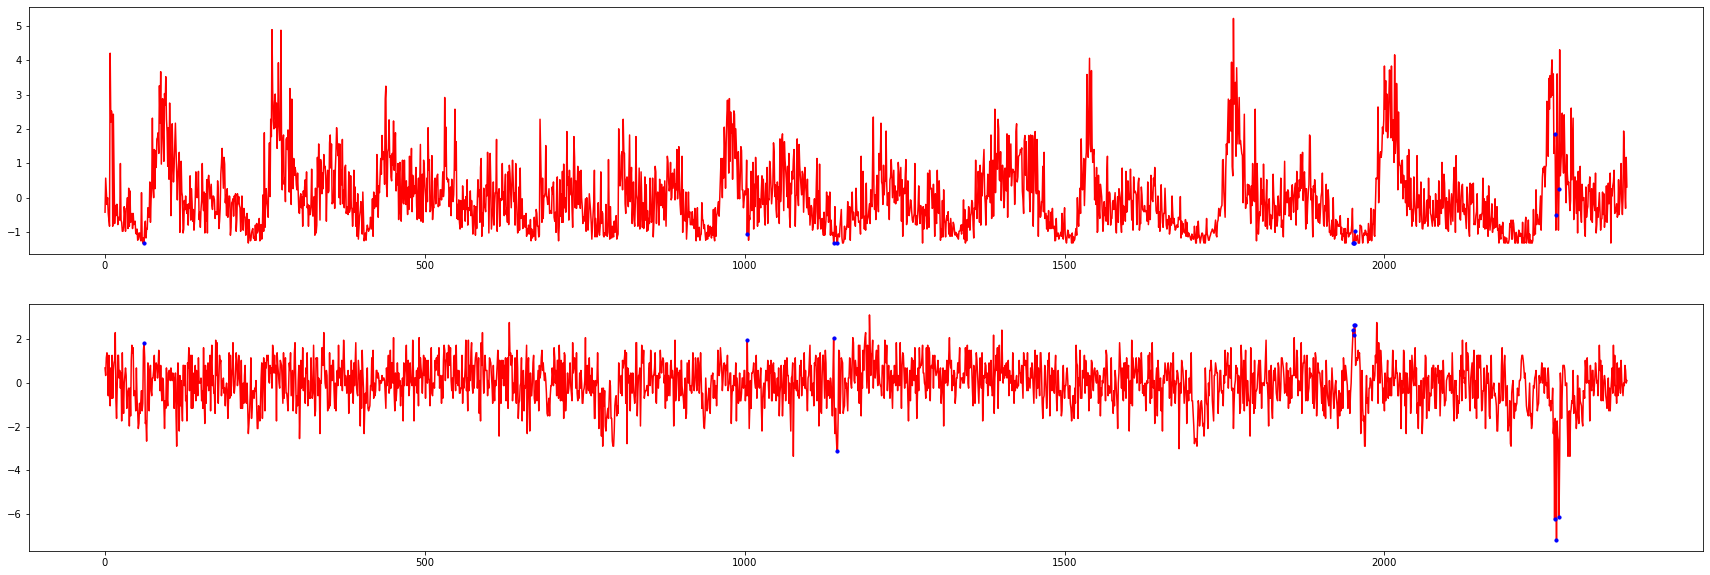

In [38]:
fig, axes = plt.subplots(2, figsize=(30,10))
x = np.arange(len(X_data[:, 0]))
axes[0].plot(x, X_data[:, 0], color='red', zorder=0)
axes[0].scatter(y_data_anomalies, X_data[y_data_anomalies, 0], s=10, color='blue', zorder=1)

axes[1].plot(x, X_data[:, 1], color='red', zorder=0)
axes[1].scatter(y_data_anomalies, X_data[y_data_anomalies, 1], color='blue', s=10, zorder=1)

plt.show()